In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
# Import system helpers
import os
import pathlib
from os import listdir
from os.path import isfile, join

# Import TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import helper libraries
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

In [3]:
# Convert .mat to Python dict with Scipy.io

sc_devkit = '/Users/katerina/Workspace/visual_census/data/devkit'

cars_meta = scipy.io.loadmat(os.path.join(sc_devkit, 'cars_meta.mat'))['class_names']
cars_train_annos = scipy.io.loadmat(os.path.join(sc_devkit, 'cars_train_annos.mat'))['annotations']

In [4]:
# Extract Car Metadata from dictionary to an array

car_makes = []
for idx, vehicle in enumerate(cars_meta[0]):
    car_makes.append([vehicle[0],vehicle[0].split(' ')[0], vehicle[0].split(' ')[-1]])
car_makes = pd.DataFrame(car_makes, columns=['full_label', 'mnfr', 'year'])
car_make_nums = np.array(car_makes.index)

In [5]:
# Extract Car Labels from dictionary to a list
# List used because both int (label) and str (img id) required

cars_train_labels = []
cars_train_annotations = []
for idx, anno in enumerate(cars_train_annos[0]):
    cars_train_labels.append(anno[4][0][0])
    cars_train_annotations.append([anno[0][0][0], anno[1][0][0], anno[2][0][0], anno[3][0][0], anno[4][0][0], anno[5][0]])
cars_train_annotations = pd.DataFrame(cars_train_annotations, columns=['bb0', 'bb1', 'bb2', 'bb3', 'label', 'img_name'])
cars_train_labels = np.array(cars_train_labels)

In [6]:
sc_cars_train = '/Users/katerina/Workspace/visual_census/data/training_data/cars_train copy'
sc_cars_test = '/Users/katerina/Workspace/visual_census/data/training_data/cars_test'
train_data_dir = pathlib.Path(sc_cars_train)
test_data_dir = pathlib.Path(sc_cars_test)

In [7]:
train_image_count = len(list(train_data_dir.glob('*.jpg')))
test_image_count = len(list(test_data_dir.glob('*.jpg')))

In [8]:
train_image_names = np.array([item.name for item in train_data_dir.glob('*')])
test_image_names = np.array([item.name for item in test_data_dir.glob('*')])

In [9]:
list_ds = tf.data.Dataset.list_files(str('/Users/katerina/Workspace/visual_census/data/training_data/cars_train copy/*'))
list_ds_test = tf.data.Dataset.list_files(str('/Users/katerina/Workspace/visual_census/data/training_data/cars_test/*'))

In [66]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

In [67]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(tf.strings.split(file_path, '_')[-1], '.')[0]
  # The last is the image name
  return parts==np.array([str(idx) for idx in car_makes.index])

In [68]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [69]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [70]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [71]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [73]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

In [74]:
test_ds = labeled_ds_test.prefetch(buffer_size=AUTOTUNE)
image_batch_test, label_batch_test = next(iter(test_ds))

In [75]:
#np.array([x[label][0] for label in label_batch]).reshape(-1,1)

In [76]:
# def show_batch(image_batch, label_batch):
#   plt.figure(figsize=(10,10))
#   for n in range(25):
#       ax = plt.subplot(5,5,n+1)
#       plt.imshow(image_batch[n])
#       plt.title(car_make_nums[label_batch[n]==1][0])
#       plt.axis('off')

# show_batch(image_batch.numpy(), label_batch.numpy())

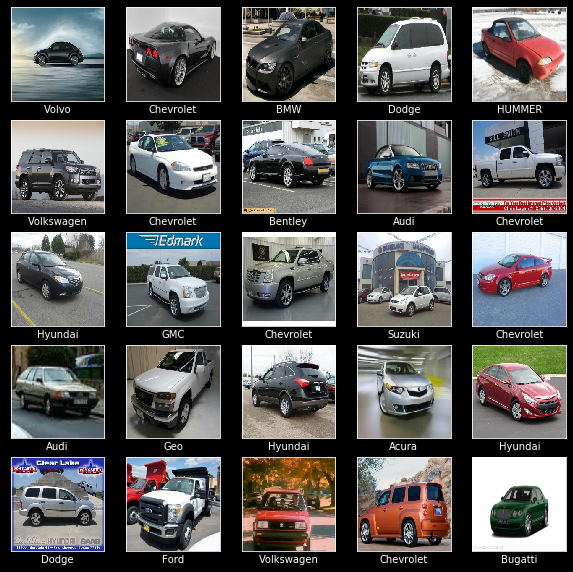

In [96]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_batch[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(np.array(car_makes['mnfr'])[label_batch[i]][0])
plt.show()

In [77]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(196, activation='softmax'))

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [79]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(image_batch, np.array([car_make_nums[label][0] for label in label_batch]), epochs=10)


Train on 32 samples
Epoch 1/10
32/32 [==============================] - 1s 40ms/sample - loss: 5.2681 - accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 1s 20ms/sample - loss: 6.2806 - accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 1s 20ms/sample - loss: 4.7011 - accuracy: 0.0625
Epoch 4/10
32/32 [==============================] - 1s 20ms/sample - loss: 4.2880 - accuracy: 0.2188
Epoch 5/10
32/32 [==============================] - 1s 20ms/sample - loss: 4.0863 - accuracy: 0.4062
Epoch 6/10
32/32 [==============================] - 1s 19ms/sample - loss: 3.5298 - accuracy: 0.5312
Epoch 7/10
32/32 [==============================] - 1s 20ms/sample - loss: 2.9237 - accuracy: 0.4688
Epoch 8/10
32/32 [==============================] - 1s 20ms/sample - loss: 2.1960 - accuracy: 0.6875
Epoch 9/10
32/32 [==============================] - 1s 20ms/sample - loss: 1.5164 - accuracy: 0.8438
Epoch 10/10
32/32 [==============================] - 1s 20ms/sa

In [62]:
# copy_path = '/Users/katerina/Workspace/visual_census/data/training_data/cars_train copy/'
# def main(): 
#     i = 0
      
#     for filename in os.listdir(copy_path):
#         dst = str(i) + '_' + str(test[filename]) + ".jpg"
#         src = copy_path + filename 
#         dst = copy_path + dst 
          
#         # rename() function will 
#         # rename all the files 
#         os.rename(src, dst) 
#         i += 1

In [63]:
# main()

In [95]:
for _ in range(10):
    image_batch_test, label_batch_test = next(iter(test_ds))
    test_loss, test_acc = model.evaluate(image_batch, np.array([car_make_nums[label] for label in label_batch]), verbose=2)

32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
32/1 - 0s - loss: 0.4129 - accuracy: 0.9375
